In [1]:
import pathlib
import numpy as np
import pandas as pd
from scipy import sparse
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import loggingScoring as ls
import matplotlib.pyplot as plt
import seaborn as sns

### Initiating Logging

In [2]:
log = ls.get_logfile('3.log')
log.info('Random Forest Classifier')

### Load Data

In [3]:
datapath = pathlib.Path('..') / 'Data'
data_loader = np.load(datapath / 'PreprocessedData.npz')
X_train = sparse.csr_matrix((data_loader['X_train_data'],
                             data_loader['X_train_indices'],
                             data_loader['X_train_indptr']),
                            shape = data_loader['X_train_shape'])
y_train = data_loader['y_train']
X_test = sparse.csr_matrix((data_loader['X_test_data'],
                            data_loader['X_test_indices'],
                            data_loader['X_test_indptr']),
                           shape = data_loader['X_test_shape'])
y_test = data_loader['y_test']

### Model

In [4]:
default_params = RandomForestClassifier().get_params()
print('Default Parameters of RandomForestClassifier :\n{}'.format(default_params))

Default Parameters of RandomForestClassifier :
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


Fit time: 11.153 s / Predict time: 0.104 s ---- Precision: 0.917 / Recall: 0.964 / Accuracy: 0.941

Classification Report :

              precision    recall  f1-score   support

        Real       0.96      0.92      0.94      3187
        Fake       0.92      0.96      0.94      2936

    accuracy                           0.94      6123
   macro avg       0.94      0.94      0.94      6123
weighted avg       0.94      0.94      0.94      6123

ROC AUC Score : 0.9414578789513597


Confusion Matrix :



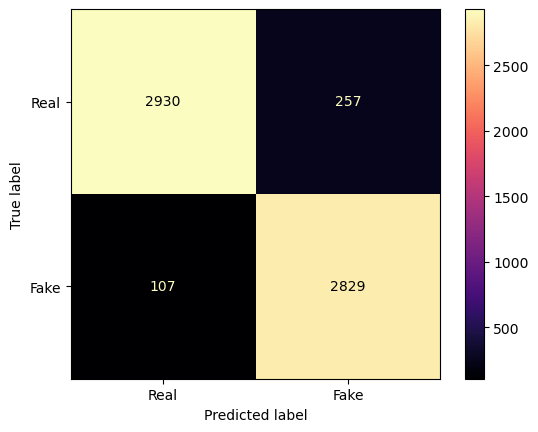

In [5]:
rf = RandomForestClassifier(n_jobs = -1, random_state = 76)

start = time.time()
rf_model = rf.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = rf_model.predict(X_test)
end = time.time()
pred_time = (end - start)

ls.test_results(y_test, y_pred, fit_time, pred_time)

In [6]:
new_params = rf_model.get_params()
del new_params['random_state'], new_params['n_jobs'], default_params['random_state'], default_params['n_jobs']
# since we are manually setting random_state & n-Jobs, removing those from comparison
if (default_params == new_params):
    print('No change observed in the Default Random Forest Classifier',\
                                    'parameters after fitting the data.')
else:
    print('Default Random Forest Classifier changed following parameters after fitting :')
    for key, value in default_params.items():
        if(value != new_params[key]):
            print('{} : {}'.format(key, new_params[key]))

No change observed in the Default Random Forest Classifier parameters after fitting the data.


### Hyperparameter Tuning

In [7]:
rf_cv = RandomForestClassifier(n_jobs = -1, random_state = 76)

params = {'n_estimators' : [50, 100, 200, 300, 400, 500, 600, 700, 1000],
          'max_depth' : [25, 50, 75, 100, 150, 200, None],
          'max_features' : ['sqrt', 'log2', 0.003],
          'min_samples_leaf' : [1, 3, 5, 7]}

skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 76)

gs = GridSearchCV(estimator = rf_cv,
                  param_grid = params,
                  cv = skf,
                  scoring = 'accuracy',
                  verbose = 3)

In [8]:
ls.divert_stdOut2log(log)
gs_fit = gs.fit(X_train, y_train)
ls.revert_log2stdOut()
df_cv_results = pd.DataFrame(gs_fit.cv_results_)\
                            .sort_values('mean_test_score', ascending = False)
df_cv_results.to_csv(datapath / 'HPTuningResults' / 'RandomForest_cv-results.csv', index = False)
df_cv_results[['params', 'mean_test_score']].head(10)

,params,mean_test_score
688,"{'max_depth': None, 'max_features': 'log2', 'm...",0.945469
692,"{'max_depth': None, 'max_features': 'log2', 'm...",0.945354
691,"{'max_depth': None, 'max_features': 'log2', 'm...",0.945296
689,"{'max_depth': None, 'max_features': 'log2', 'm...",0.945210
690,"{'max_depth': None, 'max_features': 'log2', 'm...",0.945095
687,"{'max_depth': None, 'max_features': 'log2', 'm...",0.944749
686,"{'max_depth': None, 'max_features': 'log2', 'm...",0.944259
685,"{'max_depth': None, 'max_features': 'log2', 'm...",0.943509
684,"{'max_depth': None, 'max_features': 'log2', 'm...",0.943192
723,"{'max_depth': None, 'max_features': 0.003, 'mi...",0.939705


[CV 2/3] END max_depth=50, max_features=log2, min_samples_leaf=3, n_estimators=100;, score=0.837 total time=   0.7s
[CV 3/3] END max_depth=50, max_features=log2, min_samples_leaf=3, n_estimators=100;, score=0.845 total time=   0.7s
[CV 1/3] END max_depth=50, max_features=log2, min_samples_leaf=3, n_estimators=200;, score=0.867 total time=   1.2s
[CV 2/3] END max_depth=50, max_features=log2, min_samples_leaf=3, n_estimators=200;, score=0.871 total time=   1.2s
[CV 3/3] END max_depth=50, max_features=log2, min_samples_leaf=3, n_estimators=200;, score=0.858 total time=   1.2s
[CV 1/3] END max_depth=50, max_features=log2, min_samples_leaf=3, n_estimators=300;, score=0.879 total time=   1.7s
[CV 2/3] END max_depth=50, max_features=log2, min_samples_leaf=3, n_estimators=300;, score=0.861 total time=   1.7s
[CV 3/3] END max_depth=50, max_features=log2, min_samples_leaf=3, n_estimators=300;, score=0.862 total time=   1.7s
[CV 1/3] END max_depth=50, max_features=log2, min_samples_leaf=3, n_esti

[CV 1/3] END max_depth=50, max_features=log2, min_samples_leaf=7, n_estimators=700;, score=0.527 total time=   2.1s
[CV 2/3] END max_depth=50, max_features=log2, min_samples_leaf=7, n_estimators=700;, score=0.530 total time=   2.1s
[CV 3/3] END max_depth=50, max_features=log2, min_samples_leaf=7, n_estimators=700;, score=0.542 total time=   2.1s
[CV 1/3] END max_depth=50, max_features=log2, min_samples_leaf=7, n_estimators=1000;, score=0.528 total time=   2.9s
[CV 2/3] END max_depth=50, max_features=log2, min_samples_leaf=7, n_estimators=1000;, score=0.530 total time=   2.9s
[CV 3/3] END max_depth=50, max_features=log2, min_samples_leaf=7, n_estimators=1000;, score=0.545 total time=   2.9s
[CV 1/3] END max_depth=75, max_features=sqrt, min_samples_leaf=1, n_estimators=50;, score=0.925 total time=   2.6s
[CV 2/3] END max_depth=75, max_features=sqrt, min_samples_leaf=1, n_estimators=50;, score=0.925 total time=   2.5s
[CV 3/3] END max_depth=75, max_features=sqrt, min_samples_leaf=1, n_est

[CV 3/3] END max_depth=75, max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.922 total time=   6.3s
[CV 1/3] END max_depth=75, max_features=sqrt, min_samples_leaf=5, n_estimators=400;, score=0.916 total time=   8.4s
[CV 2/3] END max_depth=75, max_features=sqrt, min_samples_leaf=5, n_estimators=400;, score=0.917 total time=   8.4s
[CV 3/3] END max_depth=75, max_features=sqrt, min_samples_leaf=5, n_estimators=400;, score=0.923 total time=   8.4s
[CV 1/3] END max_depth=75, max_features=sqrt, min_samples_leaf=5, n_estimators=500;, score=0.917 total time=  10.5s
[CV 2/3] END max_depth=75, max_features=sqrt, min_samples_leaf=5, n_estimators=500;, score=0.918 total time=  10.5s
[CV 3/3] END max_depth=75, max_features=sqrt, min_samples_leaf=5, n_estimators=500;, score=0.923 total time=  10.4s
[CV 1/3] END max_depth=75, max_features=sqrt, min_samples_leaf=5, n_estimators=600;, score=0.917 total time=  12.6s
[CV 2/3] END max_depth=75, max_features=sqrt, min_samples_leaf=5, n_esti

[CV 2/3] END max_depth=75, max_features=log2, min_samples_leaf=3, n_estimators=50;, score=0.823 total time=   0.4s
[CV 3/3] END max_depth=75, max_features=log2, min_samples_leaf=3, n_estimators=50;, score=0.816 total time=   0.4s
[CV 1/3] END max_depth=75, max_features=log2, min_samples_leaf=3, n_estimators=100;, score=0.865 total time=   0.7s
[CV 2/3] END max_depth=75, max_features=log2, min_samples_leaf=3, n_estimators=100;, score=0.849 total time=   0.7s
[CV 3/3] END max_depth=75, max_features=log2, min_samples_leaf=3, n_estimators=100;, score=0.859 total time=   0.8s
[CV 1/3] END max_depth=75, max_features=log2, min_samples_leaf=3, n_estimators=200;, score=0.880 total time=   1.2s
[CV 2/3] END max_depth=75, max_features=log2, min_samples_leaf=3, n_estimators=200;, score=0.882 total time=   1.3s
[CV 3/3] END max_depth=75, max_features=log2, min_samples_leaf=3, n_estimators=200;, score=0.874 total time=   1.3s
[CV 1/3] END max_depth=75, max_features=log2, min_samples_leaf=3, n_estima

[CV 1/3] END max_depth=75, max_features=log2, min_samples_leaf=7, n_estimators=600;, score=0.528 total time=   1.8s
[CV 2/3] END max_depth=75, max_features=log2, min_samples_leaf=7, n_estimators=600;, score=0.527 total time=   1.8s
[CV 3/3] END max_depth=75, max_features=log2, min_samples_leaf=7, n_estimators=600;, score=0.543 total time=   1.9s
[CV 1/3] END max_depth=75, max_features=log2, min_samples_leaf=7, n_estimators=700;, score=0.527 total time=   2.1s
[CV 2/3] END max_depth=75, max_features=log2, min_samples_leaf=7, n_estimators=700;, score=0.530 total time=   2.1s
[CV 3/3] END max_depth=75, max_features=log2, min_samples_leaf=7, n_estimators=700;, score=0.542 total time=   2.1s
[CV 1/3] END max_depth=75, max_features=log2, min_samples_leaf=7, n_estimators=1000;, score=0.528 total time=   2.9s
[CV 2/3] END max_depth=75, max_features=log2, min_samples_leaf=7, n_estimators=1000;, score=0.530 total time=   2.9s
[CV 3/3] END max_depth=75, max_features=log2, min_samples_leaf=7, n_es

[CV 3/3] END max_depth=100, max_features=sqrt, min_samples_leaf=5, n_estimators=200;, score=0.925 total time=   5.0s
[CV 1/3] END max_depth=100, max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.920 total time=   7.5s
[CV 2/3] END max_depth=100, max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.919 total time=   7.3s
[CV 3/3] END max_depth=100, max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.925 total time=   7.2s
[CV 1/3] END max_depth=100, max_features=sqrt, min_samples_leaf=5, n_estimators=400;, score=0.919 total time=   9.1s
[CV 2/3] END max_depth=100, max_features=sqrt, min_samples_leaf=5, n_estimators=400;, score=0.919 total time=   9.0s
[CV 3/3] END max_depth=100, max_features=sqrt, min_samples_leaf=5, n_estimators=400;, score=0.926 total time=   9.2s
[CV 1/3] END max_depth=100, max_features=sqrt, min_samples_leaf=5, n_estimators=500;, score=0.919 total time=  11.4s
[CV 2/3] END max_depth=100, max_features=sqrt, min_samples_leaf=

[CV 2/3] END max_depth=100, max_features=log2, min_samples_leaf=1, n_estimators=1000;, score=0.932 total time=  23.3s
[CV 3/3] END max_depth=100, max_features=log2, min_samples_leaf=1, n_estimators=1000;, score=0.940 total time=  23.3s
[CV 1/3] END max_depth=100, max_features=log2, min_samples_leaf=3, n_estimators=50;, score=0.865 total time=   0.5s
[CV 2/3] END max_depth=100, max_features=log2, min_samples_leaf=3, n_estimators=50;, score=0.842 total time=   0.4s
[CV 3/3] END max_depth=100, max_features=log2, min_samples_leaf=3, n_estimators=50;, score=0.823 total time=   0.5s
[CV 1/3] END max_depth=100, max_features=log2, min_samples_leaf=3, n_estimators=100;, score=0.881 total time=   0.7s
[CV 2/3] END max_depth=100, max_features=log2, min_samples_leaf=3, n_estimators=100;, score=0.856 total time=   0.7s
[CV 3/3] END max_depth=100, max_features=log2, min_samples_leaf=3, n_estimators=100;, score=0.864 total time=   0.8s
[CV 1/3] END max_depth=100, max_features=log2, min_samples_leaf=3

[CV 1/3] END max_depth=100, max_features=log2, min_samples_leaf=7, n_estimators=500;, score=0.528 total time=   1.5s
[CV 2/3] END max_depth=100, max_features=log2, min_samples_leaf=7, n_estimators=500;, score=0.531 total time=   1.5s
[CV 3/3] END max_depth=100, max_features=log2, min_samples_leaf=7, n_estimators=500;, score=0.543 total time=   1.5s
[CV 1/3] END max_depth=100, max_features=log2, min_samples_leaf=7, n_estimators=600;, score=0.528 total time=   1.8s
[CV 2/3] END max_depth=100, max_features=log2, min_samples_leaf=7, n_estimators=600;, score=0.527 total time=   1.8s
[CV 3/3] END max_depth=100, max_features=log2, min_samples_leaf=7, n_estimators=600;, score=0.543 total time=   1.8s
[CV 1/3] END max_depth=100, max_features=log2, min_samples_leaf=7, n_estimators=700;, score=0.527 total time=   2.0s
[CV 2/3] END max_depth=100, max_features=log2, min_samples_leaf=7, n_estimators=700;, score=0.530 total time=   2.1s
[CV 3/3] END max_depth=100, max_features=log2, min_samples_leaf=

[CV 2/3] END max_depth=None, max_features=sqrt, min_samples_leaf=5, n_estimators=100;, score=0.921 total time=   2.6s
[CV 3/3] END max_depth=None, max_features=sqrt, min_samples_leaf=5, n_estimators=100;, score=0.926 total time=   2.7s
[CV 1/3] END max_depth=None, max_features=sqrt, min_samples_leaf=5, n_estimators=200;, score=0.921 total time=   4.8s
[CV 2/3] END max_depth=None, max_features=sqrt, min_samples_leaf=5, n_estimators=200;, score=0.920 total time=   4.7s
[CV 3/3] END max_depth=None, max_features=sqrt, min_samples_leaf=5, n_estimators=200;, score=0.926 total time=   4.8s
[CV 1/3] END max_depth=None, max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.921 total time=   7.1s
[CV 2/3] END max_depth=None, max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.919 total time=   7.4s
[CV 3/3] END max_depth=None, max_features=sqrt, min_samples_leaf=5, n_estimators=300;, score=0.926 total time=   7.1s
[CV 1/3] END max_depth=None, max_features=sqrt, min_samp

[CV 3/3] END max_depth=None, max_features=log2, min_samples_leaf=1, n_estimators=600;, score=0.954 total time= 1.1min
[CV 1/3] END max_depth=None, max_features=log2, min_samples_leaf=1, n_estimators=700;, score=0.950 total time= 1.3min
[CV 2/3] END max_depth=None, max_features=log2, min_samples_leaf=1, n_estimators=700;, score=0.950 total time= 1.2min
[CV 3/3] END max_depth=None, max_features=log2, min_samples_leaf=1, n_estimators=700;, score=0.952 total time= 1.3min
[CV 1/3] END max_depth=None, max_features=log2, min_samples_leaf=1, n_estimators=1000;, score=0.949 total time= 1.8min
[CV 2/3] END max_depth=None, max_features=log2, min_samples_leaf=1, n_estimators=1000;, score=0.950 total time= 1.8min
[CV 3/3] END max_depth=None, max_features=log2, min_samples_leaf=1, n_estimators=1000;, score=0.953 total time= 1.8min
[CV 1/3] END max_depth=None, max_features=log2, min_samples_leaf=3, n_estimators=50;, score=0.865 total time=   0.5s
[CV 2/3] END max_depth=None, max_features=log2, min_sa

[CV 1/3] END max_depth=None, max_features=log2, min_samples_leaf=7, n_estimators=300;, score=0.530 total time=   1.0s
[CV 2/3] END max_depth=None, max_features=log2, min_samples_leaf=7, n_estimators=300;, score=0.539 total time=   1.0s
[CV 3/3] END max_depth=None, max_features=log2, min_samples_leaf=7, n_estimators=300;, score=0.545 total time=   1.0s
[CV 1/3] END max_depth=None, max_features=log2, min_samples_leaf=7, n_estimators=400;, score=0.528 total time=   1.2s
[CV 2/3] END max_depth=None, max_features=log2, min_samples_leaf=7, n_estimators=400;, score=0.534 total time=   1.2s
[CV 3/3] END max_depth=None, max_features=log2, min_samples_leaf=7, n_estimators=400;, score=0.542 total time=   1.3s
[CV 1/3] END max_depth=None, max_features=log2, min_samples_leaf=7, n_estimators=500;, score=0.528 total time=   1.5s
[CV 2/3] END max_depth=None, max_features=log2, min_samples_leaf=7, n_estimators=500;, score=0.531 total time=   1.5s
[CV 3/3] END max_depth=None, max_features=log2, min_samp

As can be seen, the results are very close to the baseline, worse than what we achieved with Logistic Regression.

In [9]:
gs_fit.best_estimator_

RandomForestClassifier(max_features='log2', n_estimators=400, n_jobs=-1,
                       random_state=76)

### Best Model

Fit time: 40.401 s / Predict time: 0.775 s ---- Precision: 0.917 / Recall: 0.964 / Accuracy: 0.941

Classification Report :

              precision    recall  f1-score   support

        Real       0.96      0.92      0.94      3187
        Fake       0.92      0.96      0.94      2936

    accuracy                           0.94      6123
   macro avg       0.94      0.94      0.94      6123
weighted avg       0.94      0.94      0.94      6123

ROC AUC Score : 0.9414578789513597


Confusion Matrix :



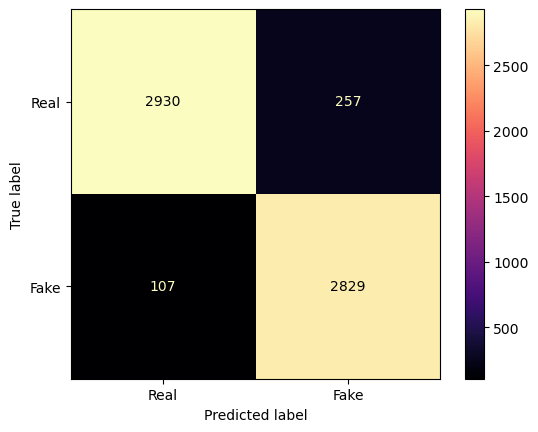

In [10]:
rf_best = RandomForestClassifier(max_depth = None,
                                 n_estimators = 400,
                                 max_features = 'log2',
                                 min_samples_leaf = 1,
                                 random_state = 76,
                                 n_jobs = -1)
# max_depth and min_samples_leaf are not mentioned in the best_estimator_, probably because these are the default values

start = time.time()
rf_model_best = rf_best.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred_best = rf_model_best.predict(X_test)
end = time.time()
pred_time = (end - start)

ls.test_results(y_test, y_pred, fit_time, pred_time)